In [1]:
import numpy as np
import matplotlib.pyplot as plt
import module

global test # test is used to store data that can be used for debugging or testing purposes.
test = 0

def compute_proxy_nodes_from_esn(esn, action_nodes,  num_proxy_nodes, trials=10, steps=500, discard=0, inverse=False, plot=False, figname = ""):  
    """
    Compute proxy nodes by selecting nodes that maximize temporal correlation with the goal nodes.
    Generates multiple random agent actions to test correlations.

    Parameters
    ----------
    esn : EchoStateNetwork
        Instance of the Echo State Network.
    action_nodes : array-like
        Indices of nodes controlled by the agent.
    goal_nodes : array-like
        Indices of the goal nodes.
    num_proxy_nodes : int
        Number of proxy nodes to select.
    trials : int, optional
        Number of random agent action sets to generate, by default 10.
    steps : int, optional
        Number of steps to run the ESN for each random action set, by default 500.
    discard : int, optional
        Number of initial steps to discard (transient period), by default 100.

    Returns
    -------
    np.ndarray
        Indices of the selected proxy nodes.
    """

    goal_nodes = np.array([esn.n-1]) 
    if plot:
        fig, axes = plt.subplots(2, 6, figsize=(50, 15))
        distance =  esn.distance(action_nodes, goal_nodes)
        fig.suptitle('Examples of random node value in 1 ESN, distance to the actions: '+ str(distance), fontsize=20)
        axes[0,0].set_ylabel('Value in the ESN', fontsize=20) 

    
    num_nodes = esn.n
    possible_nodes =  [i for i in range(num_nodes) if i not in action_nodes and i not in goal_nodes]
    run_data_base = np.zeros((trials, num_nodes))
    avg_goal_values = []
    avg_proxy_values = []
    for k in range(trials):
        # Generate random agent actions
        action_node_values = np.random.choice([-1.0, 0.0, 1.0], size=len(action_nodes))
        
        # Run the ESN with the random agent actions
        states = esn.run(steps=steps, discard=discard, agent_nodes=action_nodes, agent_values=action_node_values)
        run_data_base[k] =  np.mean(states[:, :], axis=0)

        # Compute the average values 
        avg_goal_values.append(np.mean(states[:, goal_nodes], axis=0))
        avg_proxy_values.append(np.mean(states[:, possible_nodes], axis=0))

        if k< 6 and plot:
            
            axes[0,k].set_xlabel('temporal steps', fontsize=20)
            axes[0,k].set_ylim(-1, 1)
            axes[0,k].plot(states[:, goal_nodes], label ='Goal Nodes', linestyle='--', linewidth=3)



    #print("run_data_base", run_data_base)
    # Compute correlation of each node with the goal values
    #print(run_data_base, np.corrcoef(run_data_base, rowvar= False),goal_nodes)
    global test
    test = run_data_base
    correlations = np.mean(np.corrcoef(run_data_base, rowvar= False)[:, goal_nodes], axis=1)
    #print("correlations", correlations) 
    
    # check if there are nan values in correlations
    if np.isnan(correlations).any():
        print("Warning: NaN values found in correlations. Restarting with a new ESN.")
        return compute_proxy_nodes_from_esn(esn, action_nodes, goal_nodes, num_proxy_nodes, trials=10, steps=500, discard=0, inverse=False, plot=False, figname = "") 
        

    # Sort nodes by correlation in descending order and select top nodes
    sorted_indices = [k for k in np.argsort(correlations)[::-1 + 2*inverse] if k in possible_nodes]
    proxy_nodes = sorted_indices[:num_proxy_nodes]
    #print('sorted correlations', [correlations[k] for k in proxy_nodes if k in possible_nodes] )
    #print("corr_before",correlations[proxy_nodes])

    #print("goal value", avg_goal_values)


    if plot:
        gs0 = axes[1, 0].get_gridspec()
        gs1 = axes[1, 3].get_gridspec()
        # remove the underlying Axes
        for ax in axes[-1, :]:
            ax.remove()
        axB0 = fig.add_subplot(gs1[1:, 0:3])
        axB1 = fig.add_subplot(gs1[1:, 3:6])
        axB0.set_title('Histogram of Node Values over '+ str(trials)+ ' Trials', fontsize=20)
        axB0.set_xlim(-1, 1)
        axB0.hist([k[0] for k in avg_goal_values],range=[-1, 1], bins=50)
        axB1.set_xlim(-1, 1)
        axB1.hist([k for k in correlations],range=[-1, 1], bins=50)
        axB1.set_title('Node Correlations with Goal Nodes', fontsize=20)
        fig.tight_layout()
        if figname != "":
            plt.savefig(figname + ".png")
            plt.close()
        """ plt.figure(figsize=(10, 5))
        plt.plot(states[:, proxy_nodes], label =['Proxy' + str(i) for i in range(num_proxy_nodes)], linestyle='-')
        plt.plot(states[:, goal_nodes], label ='Goal Nodes', linestyle='--', linewidth=3)
        plt.title('Node Correlations with Goal Nodes')
        plt.xlabel('temporal steps')
        plt.ylabel('Value in the ESN')
        plt.ylim(-1, 1)
        plt.legend()
        plt.grid()
        plt.show() """

    #print("goal base", np.mean(avg_goal_values))
    #print("example proxy ",[np.mean(states[:, node]) for node in proxy_nodes])
    goal_value = np.mean(avg_goal_values)
    proxy_value = np.mean(avg_proxy_values)

    return proxy_nodes, goal_value, proxy_value, correlations

In [6]:
# Example parameters
n = 4000  # Total nodes
k = 5  # Number of agent-controlled nodes
goal_nodes = np.array([n//2+1])  # Indices of goal nodes
num_proxy_nodes = 5  # Number of proxy nodes to select
action_nodes = np.array([j for j in range(k)])  # Indices of agent-controlled nodes
trials = 1000  # Number of random actions to generate
discard = 00  # Number of steps to discard for transient period
steps = 50  # Number of steps to run the ESN
inverse = False  # Whether to select nodes with minimum correlation
number_of_edges = 400  # Number of edges per node (not used in this function, but required for ESN initialization)
# Initialize the Echo State Network
#esn = module.EchoStateNetwork(n, spectral_radius=3, alpha = 0.5)
esn =  module.EchoStateNetwork(n, spectral_radius=3, alpha = 0.5, avg_number_of_edges=number_of_edges, action_nodes=action_nodes)


# Compute proxy nodes
proxy_nodes, goal_base_value, proxy_base_value, correlations = compute_proxy_nodes_from_esn(esn, action_nodes,  num_proxy_nodes, trials=trials, discard=discard, steps = steps, plot =True, inverse=inverse, figname = "parameter_exploration/test_proxy_nodes")

print("Selected proxy nodes:", proxy_nodes)
print("Goal base value:", goal_base_value)
print("Proxy base value:", proxy_base_value)

Selected proxy nodes: [np.int64(1387), np.int64(1507), np.int64(2128), np.int64(1434), np.int64(3162)]
Goal base value: 0.011105453388481831
Proxy base value: 3.232514718674296e-05


In [8]:
# create a dictionary with multiple value of a the parameters and try all the combinations  
param_grid = {
    'n': [400],
    'k': [16],
    'num_proxy_nodes': [1],
    'trials': [100],
    'discard': [ 500],
    'add_steps': [50],
    'inverse': [False],
    'plot': [True],
    'spectral_radius': [1.5],
    'alpha': [0.1],
    "plot": [True], 
    "avg_number_of_edges": [1,2,3,4,5,6,7,8,9,10]
}

# creates a list of the parameters that will vary
varying_params = [a for a in param_grid.keys() if len(param_grid[a]) > 1]
# Create a list of all combinations of parameters
from itertools import product
param_combinations = list(product(*param_grid.values()))
print("param_combinations", len(param_combinations))
# Create a list of parameter names
param_names = list(param_grid.keys())
# Loop through all combinations of parameters
for params in param_combinations:
    # Create a dictionary of parameters
    param_dict = dict(zip(param_names, params))
    print("param_dict", param_dict)
    figure_name = 'parameter_exploration/ESN_'+ "".join([a +'_'+ str(b) +'_' for (a,b) in list(zip(param_names, params)) if a in varying_params]) + '.png'
    print("figure_name", figure_name)

    param_dict["figname"] = figure_name
    param_dict["steps"] = param_dict['add_steps'] + param_dict['discard']
    param_dict['action_nodes'] = np.array([j for j in range(param_dict['k'])])

    param_dict['esn'] = module.EchoStateNetwork(param_dict['n'],  spectral_radius=param_dict['spectral_radius'], alpha = param_dict['alpha'], avg_number_of_edges=param_dict['avg_number_of_edges'], action_nodes=param_dict['action_nodes'])

    spectral_radius = param_dict['spectral_radius']
    alpha = param_dict['alpha']
    add_steps = param_dict['add_steps']
    n = param_dict['n']

    param_dict.pop('alpha')
    param_dict.pop('spectral_radius')
    param_dict.pop('add_steps')
    param_dict.pop('n')
    param_dict.pop('k')
    param_dict.pop('avg_number_of_edges')

    proxy_nodes, goal_base_value, proxy_base_value, correlations = compute_proxy_nodes_from_esn(**param_dict)
    
    
    # Unpack the parameters





param_combinations 10
param_dict {'n': 400, 'k': 16, 'num_proxy_nodes': 1, 'trials': 100, 'discard': 500, 'add_steps': 50, 'inverse': False, 'plot': True, 'spectral_radius': 1.5, 'alpha': 0.1, 'avg_number_of_edges': 1}
figure_name parameter_exploration/ESN_avg_number_of_edges_1_.png
param_dict {'n': 400, 'k': 16, 'num_proxy_nodes': 1, 'trials': 100, 'discard': 500, 'add_steps': 50, 'inverse': False, 'plot': True, 'spectral_radius': 1.5, 'alpha': 0.1, 'avg_number_of_edges': 2}
figure_name parameter_exploration/ESN_avg_number_of_edges_2_.png
param_dict {'n': 400, 'k': 16, 'num_proxy_nodes': 1, 'trials': 100, 'discard': 500, 'add_steps': 50, 'inverse': False, 'plot': True, 'spectral_radius': 1.5, 'alpha': 0.1, 'avg_number_of_edges': 3}
figure_name parameter_exploration/ESN_avg_number_of_edges_3_.png
param_dict {'n': 400, 'k': 16, 'num_proxy_nodes': 1, 'trials': 100, 'discard': 500, 'add_steps': 50, 'inverse': False, 'plot': True, 'spectral_radius': 1.5, 'alpha': 0.1, 'avg_number_of_edges'

C:\Users\paulb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\paulb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0.9998771368770617 0.8566168969024444


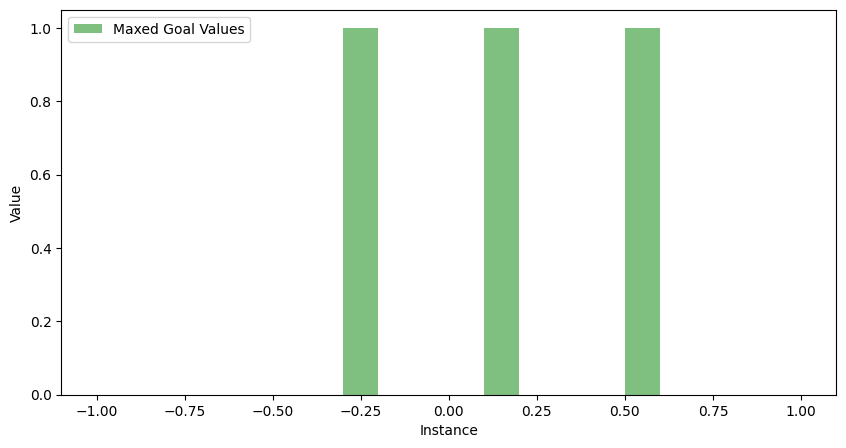

In [10]:
import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt

def run_proxy_optimization_test(esn, steps, discard, action_nodes,  trials, proxy_nodes,  inverse=False):
    """

    """
    
        # Define goal and agent nodes
    n = esn.n 
    goal_nodes = np.array([n-1])  # the goal node is the last node by permutation it is similar to a random pick 
    # Initialize the Echo State Network
    num_action_nodes = len(action_nodes)



    
    # define function to test an agent action 
    def test_agent_action(agent_action, action_value):
        """
        Test the average value of an action node if all other nodes are set to random values
        """
        action_node_values = [0.0 for i in range(num_action_nodes)]
        action_node_values[agent_action] = action_value
        run_data_base = [0 for i in range(trials)]
        proxy_samples    = []
        goal_samples    = []
        for j in range(trials): 
            for i in range(num_action_nodes):
                if i != agent_action:
                    action_node_values[i] = np.random.choice([-1.0, 0.0, 1.0])
            states = esn.run(steps=steps, discard=discard, agent_nodes=action_nodes, agent_values=action_node_values)
            proxy_samples.append(np.mean(states[:, proxy_nodes]))
            goal_samples.append(np.mean(states[:, goal_nodes]))
            run_data_base[j] =  np.mean(states[:, :], axis=0)
        #print("run_data_base", run_data_base, proxy_nodes, goal_nodes)
        return np.mean(proxy_samples), np.mean(goal_samples), run_data_base


    action_node_values = [0.0 for i in range(num_action_nodes)]

    # test all possible agent values
    max_proxy_value = -np.inf
    goal_value_on_max_proxy = -np.inf
    correlation_on_max_proxy = 0
    run_db_on_max_proxy = 0
    for i in range(num_action_nodes):
        for val in [-1.0, 1.0]:
            action_node_values[i] = val
            proxy_value, goal_value, run_db = test_agent_action(i, val)
            if proxy_value > max_proxy_value:
                max_proxy_value = proxy_value
                goal_value_on_max_proxy = goal_value
                run_db_on_max_proxy = run_db

    post_correlation = np.mean(np.corrcoef(run_db_on_max_proxy, rowvar= False)[:, goal_nodes], axis=1)
    correlation_on_max_proxy = np.mean(post_correlation[proxy_nodes])
    
    # Return the average difference in correlation
    
    
    return (goal_value_on_max_proxy, max_proxy_value, correlation_on_max_proxy)

# Example usage
num_instances = 10
n = 500  # Total nodes
num_proxy_nodes = 1
steps = 150
discard = 100
trials = 3
num_action_nodes = 10
inverse = False

#average_goal_base, average_proxy_base, maxed_goal_value, maxed_proxy_value = run_proxy_optimization_test(n, num_proxy_nodes, steps, discard, num_action_nodes, trials, inverse)
#print("Average value of the goal base", average_goal_base)
#print("Average value of the goal", maxed_goal_value)

#print("Average value of the proxy base", average_proxy_base)
#print("Average value of the proxy", maxed_proxy_value)

list_of_goal_base = []
list_of_proxy_base = []

list_of_maxed_goal_value = []
list_of_maxed_proxy_value = []

num_instances = 3
for i in range(num_instances):
    action_nodes = np.array([i for i in range(num_action_nodes)])  # First 10 nodes as agent-controlled nodes
    esn =  module.EchoStateNetwork(n, spectral_radius=2, alpha = 0.1, avg_number_of_edges=4, action_nodes=action_nodes)

        # Compute proxy nodes
    proxy_nodes, goal_base, proxy_base, correlations = compute_proxy_nodes_from_esn(esn, action_nodes,  num_proxy_nodes, 
                                            trials=trials, steps=steps, discard=discard, inverse=inverse)
    correlation_base = np.mean(correlations[proxy_nodes])
    
    maxed_goal_value, maxed_proxy_value, correlation_on_max_proxy = run_proxy_optimization_test(esn, steps, discard, action_nodes,  trials,  proxy_nodes, inverse=False)
    list_of_goal_base.append(goal_base)
    list_of_proxy_base.append(proxy_base)
    list_of_maxed_goal_value.append(maxed_goal_value-goal_base)
    list_of_maxed_proxy_value.append(maxed_proxy_value)
plt.figure(figsize=(10, 5))
#plt.hist(list_of_goal_base, bins=20, alpha=0.5,range=[-1, 1], label='Goal Base Values', color='blue')
#plt.hist(list_of_proxy_base, bins=20, alpha=0.5,range=[-1, 1], label='Proxy Base Values', color='orange')
plt.hist(list_of_maxed_goal_value, bins=20, alpha=0.5,range=[-1, 1], label='Maxed Goal Values', color='green')
#plt.hist(list_of_maxed_proxy_value, bins=20, alpha=0.5,range=[-1, 1], label='Maxed Proxy Values', color='red')

plt.legend()
plt.xlabel('Instance')
plt.ylabel('Value')
print(correlation_base, correlation_on_max_proxy)

In [20]:
import json

def plot_example_esn(ax, esn, steps=500, discard=100, action_nodes=None):
    action_node_values = np.random.choice([-1.0, 0.0, 1.0], size=len(action_nodes)) if action_nodes is not None else None
    states = esn.run(steps=steps, discard=discard, agent_nodes=action_nodes, agent_values=action_node_values)
    for j in range(5):
        ax.plot(states[:,(esn.n -1- j) ], label ='Goal Nodes', linewidth=1)
    ax.set_ylim(-1, 1)

def append_to_json(_dict,path): 
    with open(path, 'ab+') as f:
        f.seek(0,2)                                #Go to the end of file    
        if f.tell() == 0 :                         #Check if file is empty
            f.write(json.dumps([_dict]).encode())  #If empty, write an array
        else :
            f.seek(-1,2)           
            f.truncate()                           #Remove the last character, open the array
            f.write(' , '.encode())                #Write the separator
            f.write(json.dumps(_dict).encode())    #Dump the dictionary
            f.write(']'.encode())   

param_combinations 16
instance 1 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 2 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 3 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 4 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 5 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 6 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 7 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 8 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 9 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 10 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 11 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
instance 12 out of  16 name parameter_exploration/ESN_avg_number_of_edges_10_.png
ins

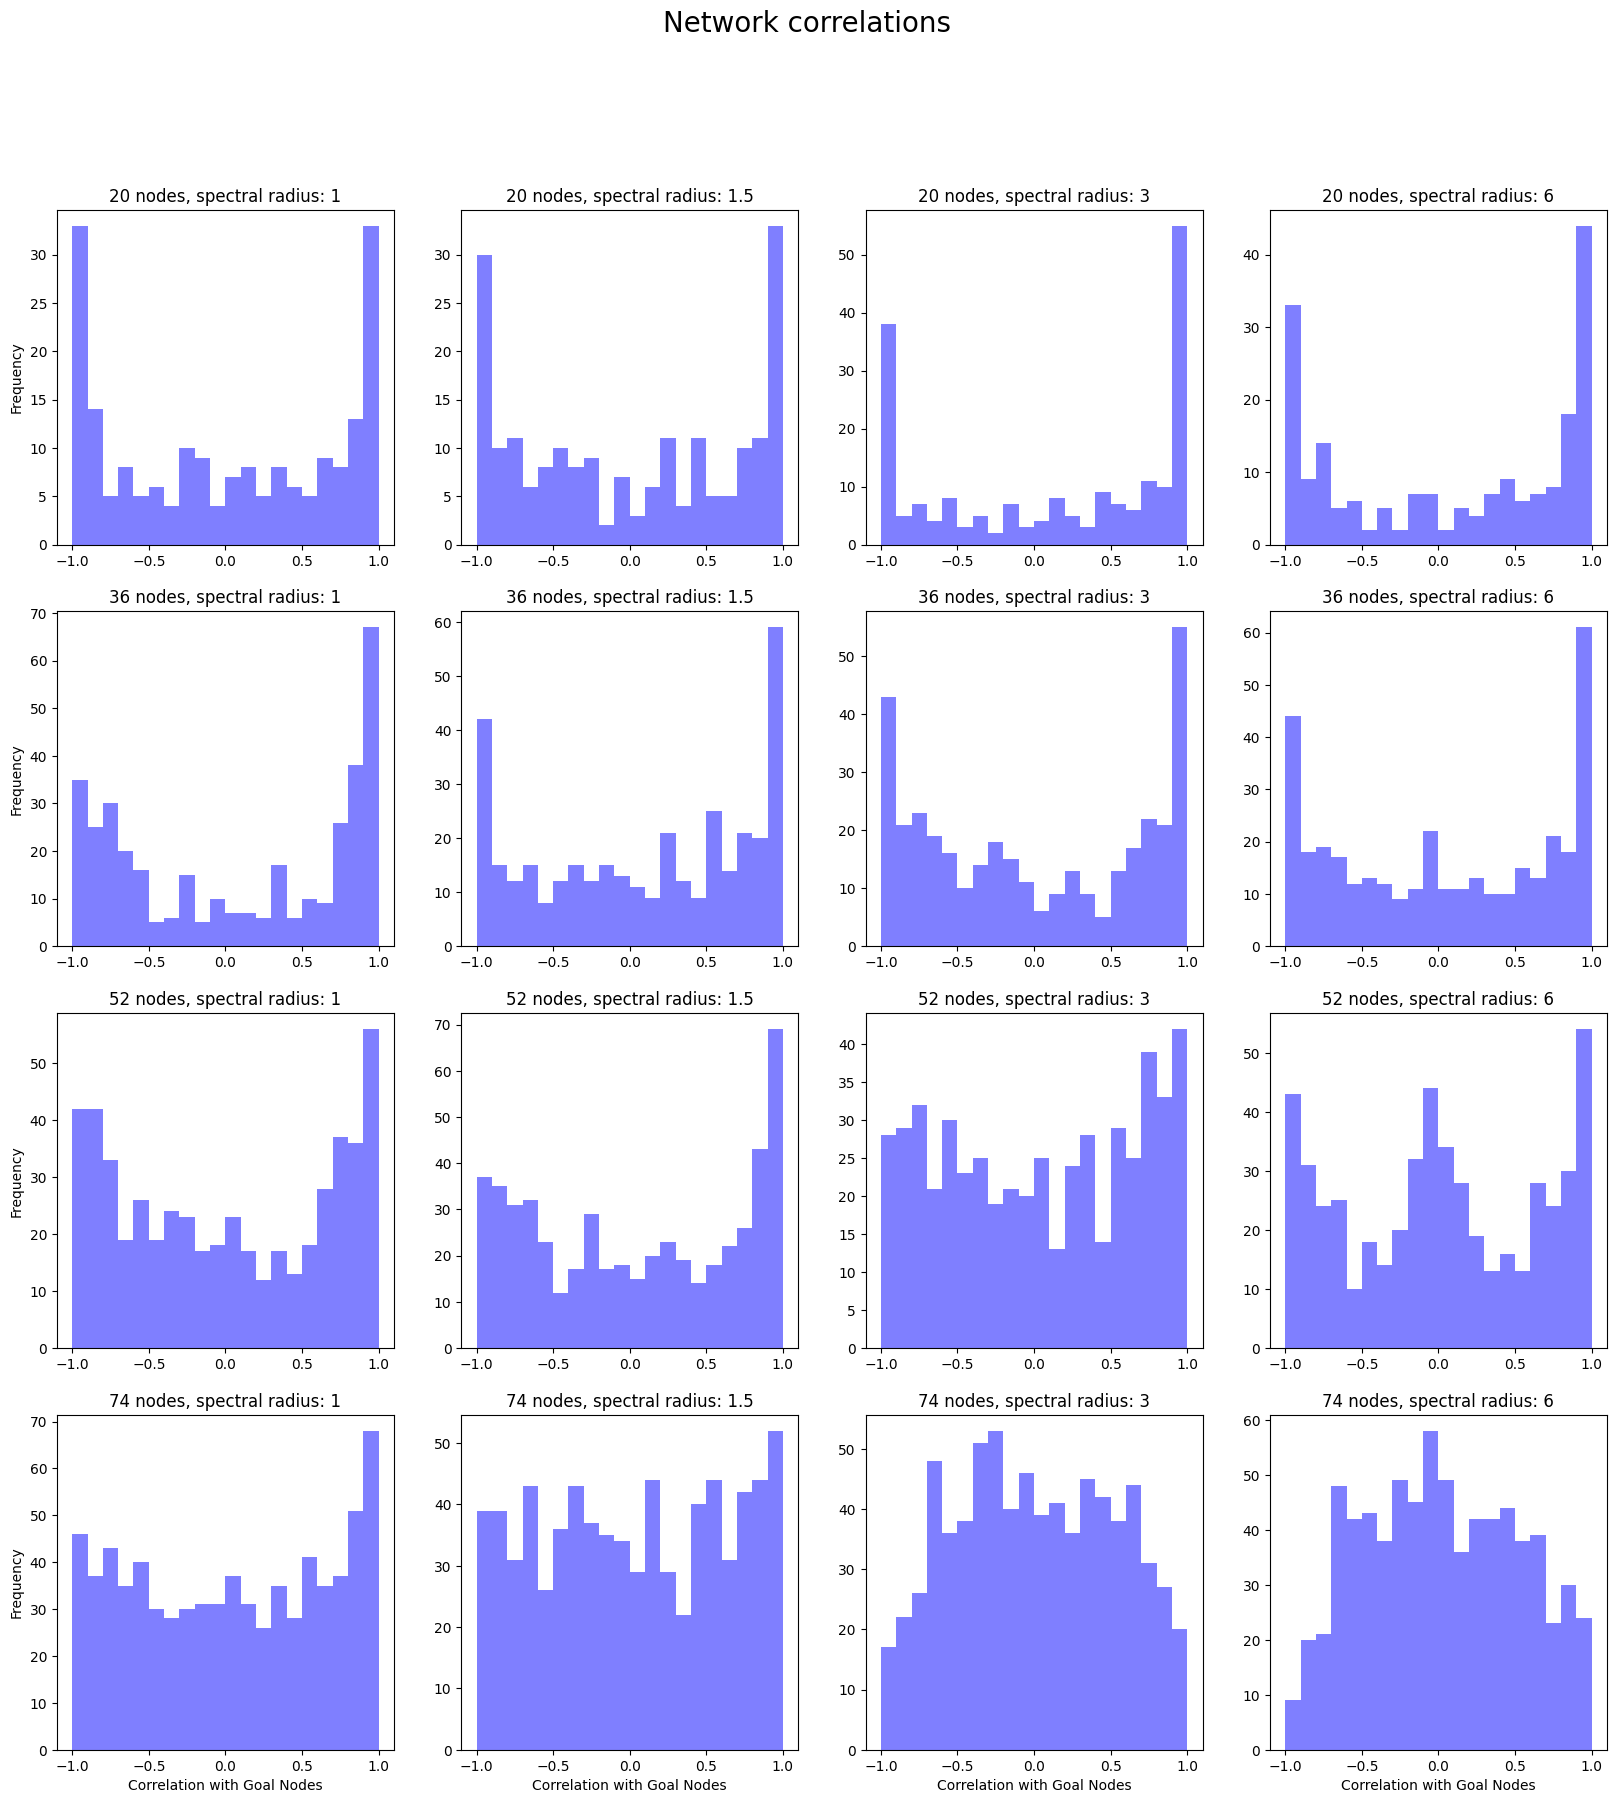

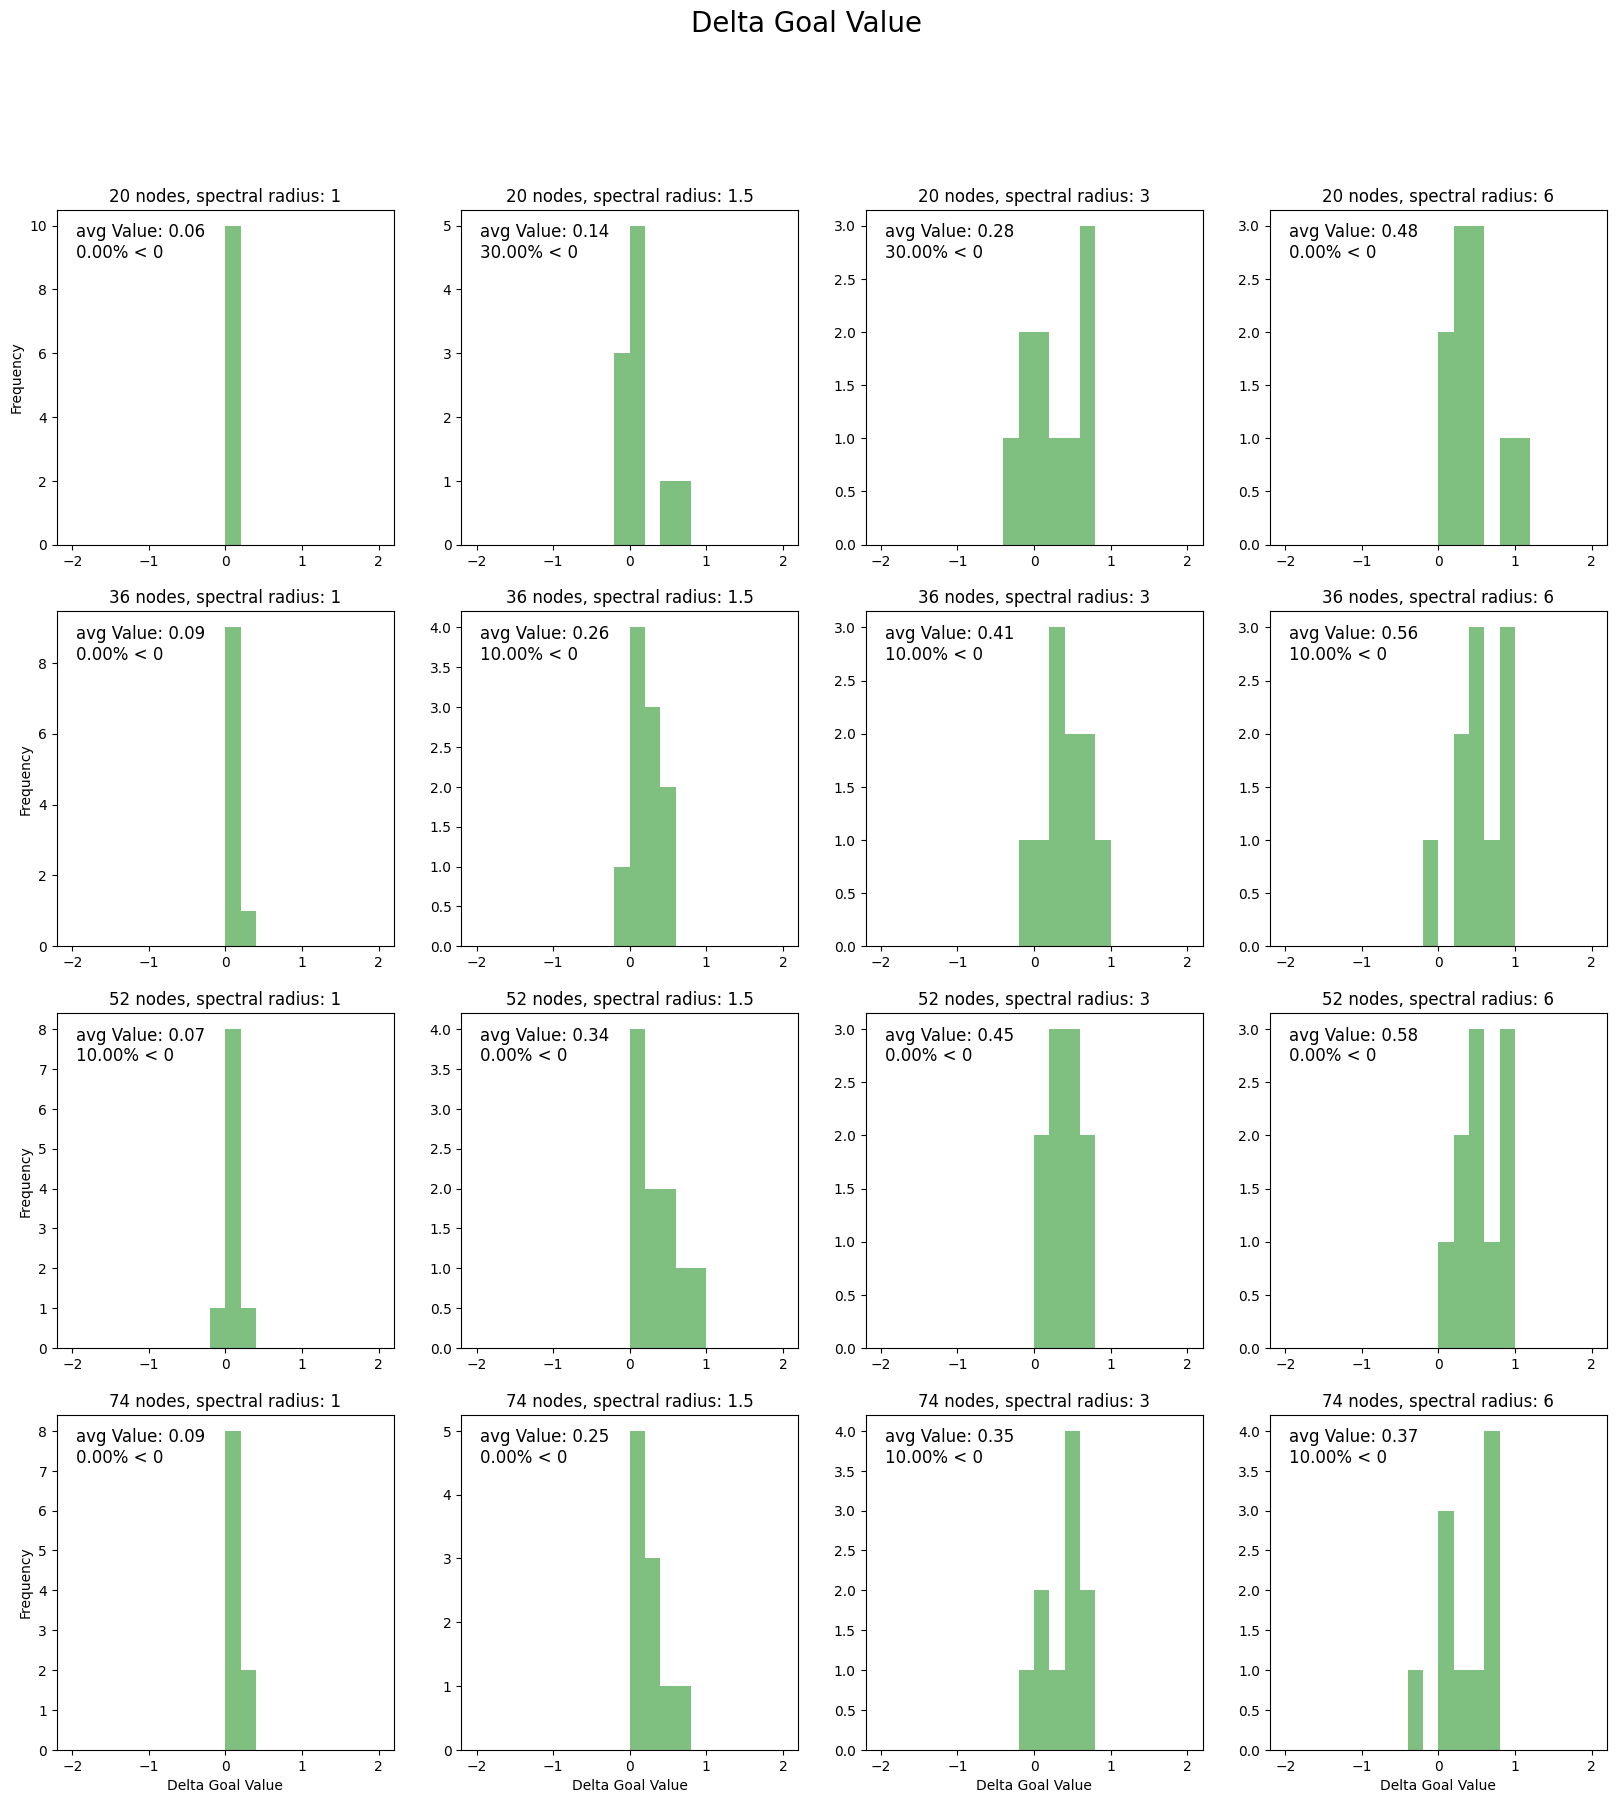

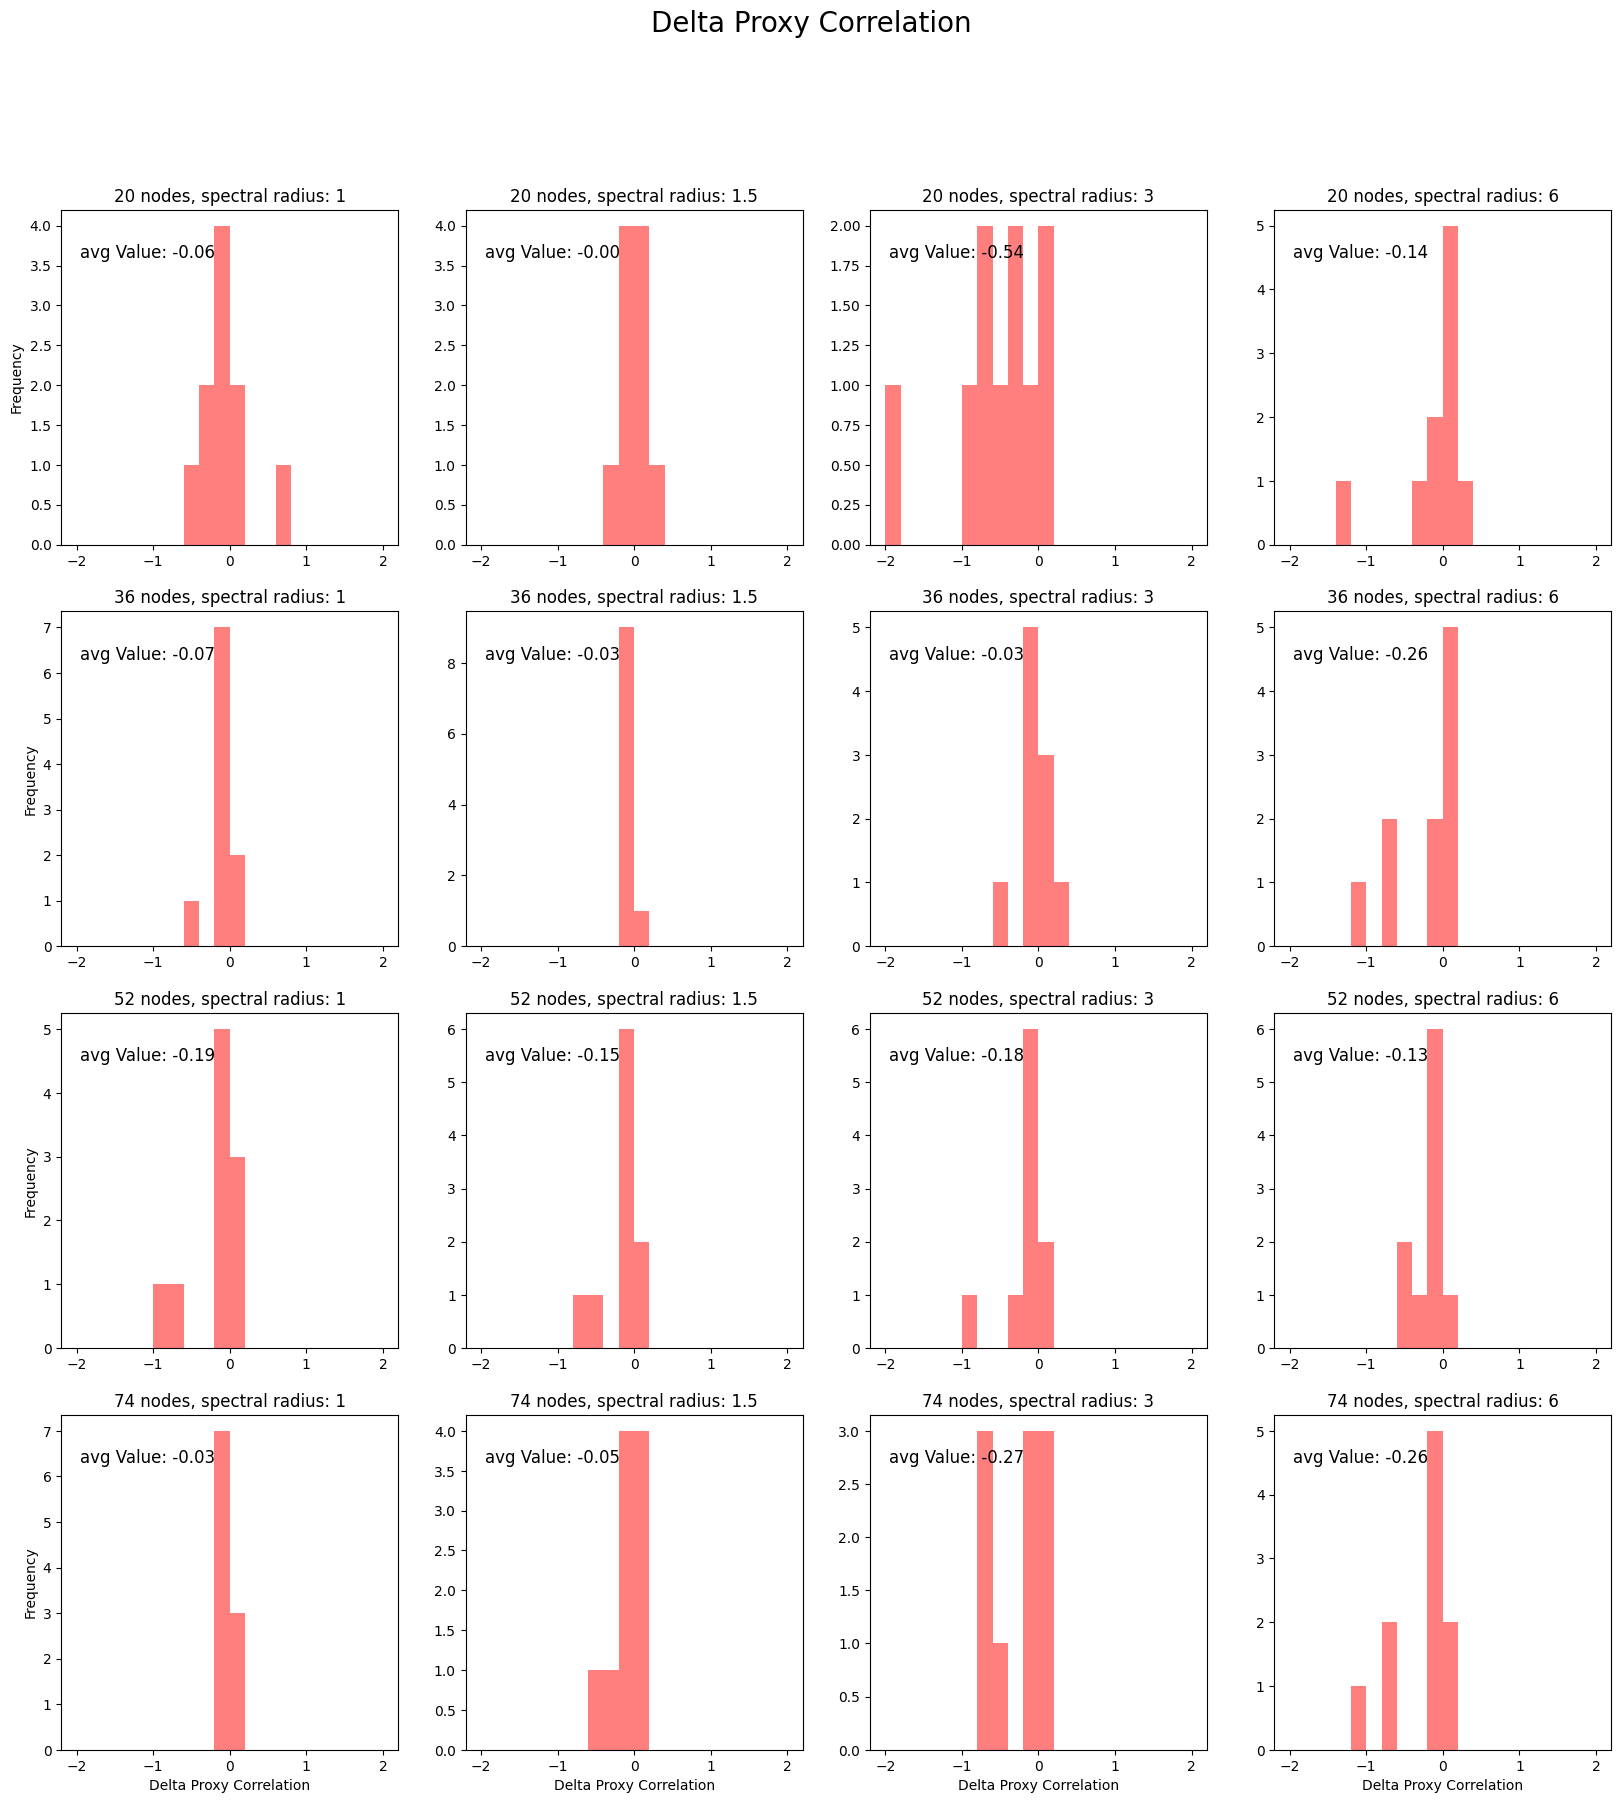

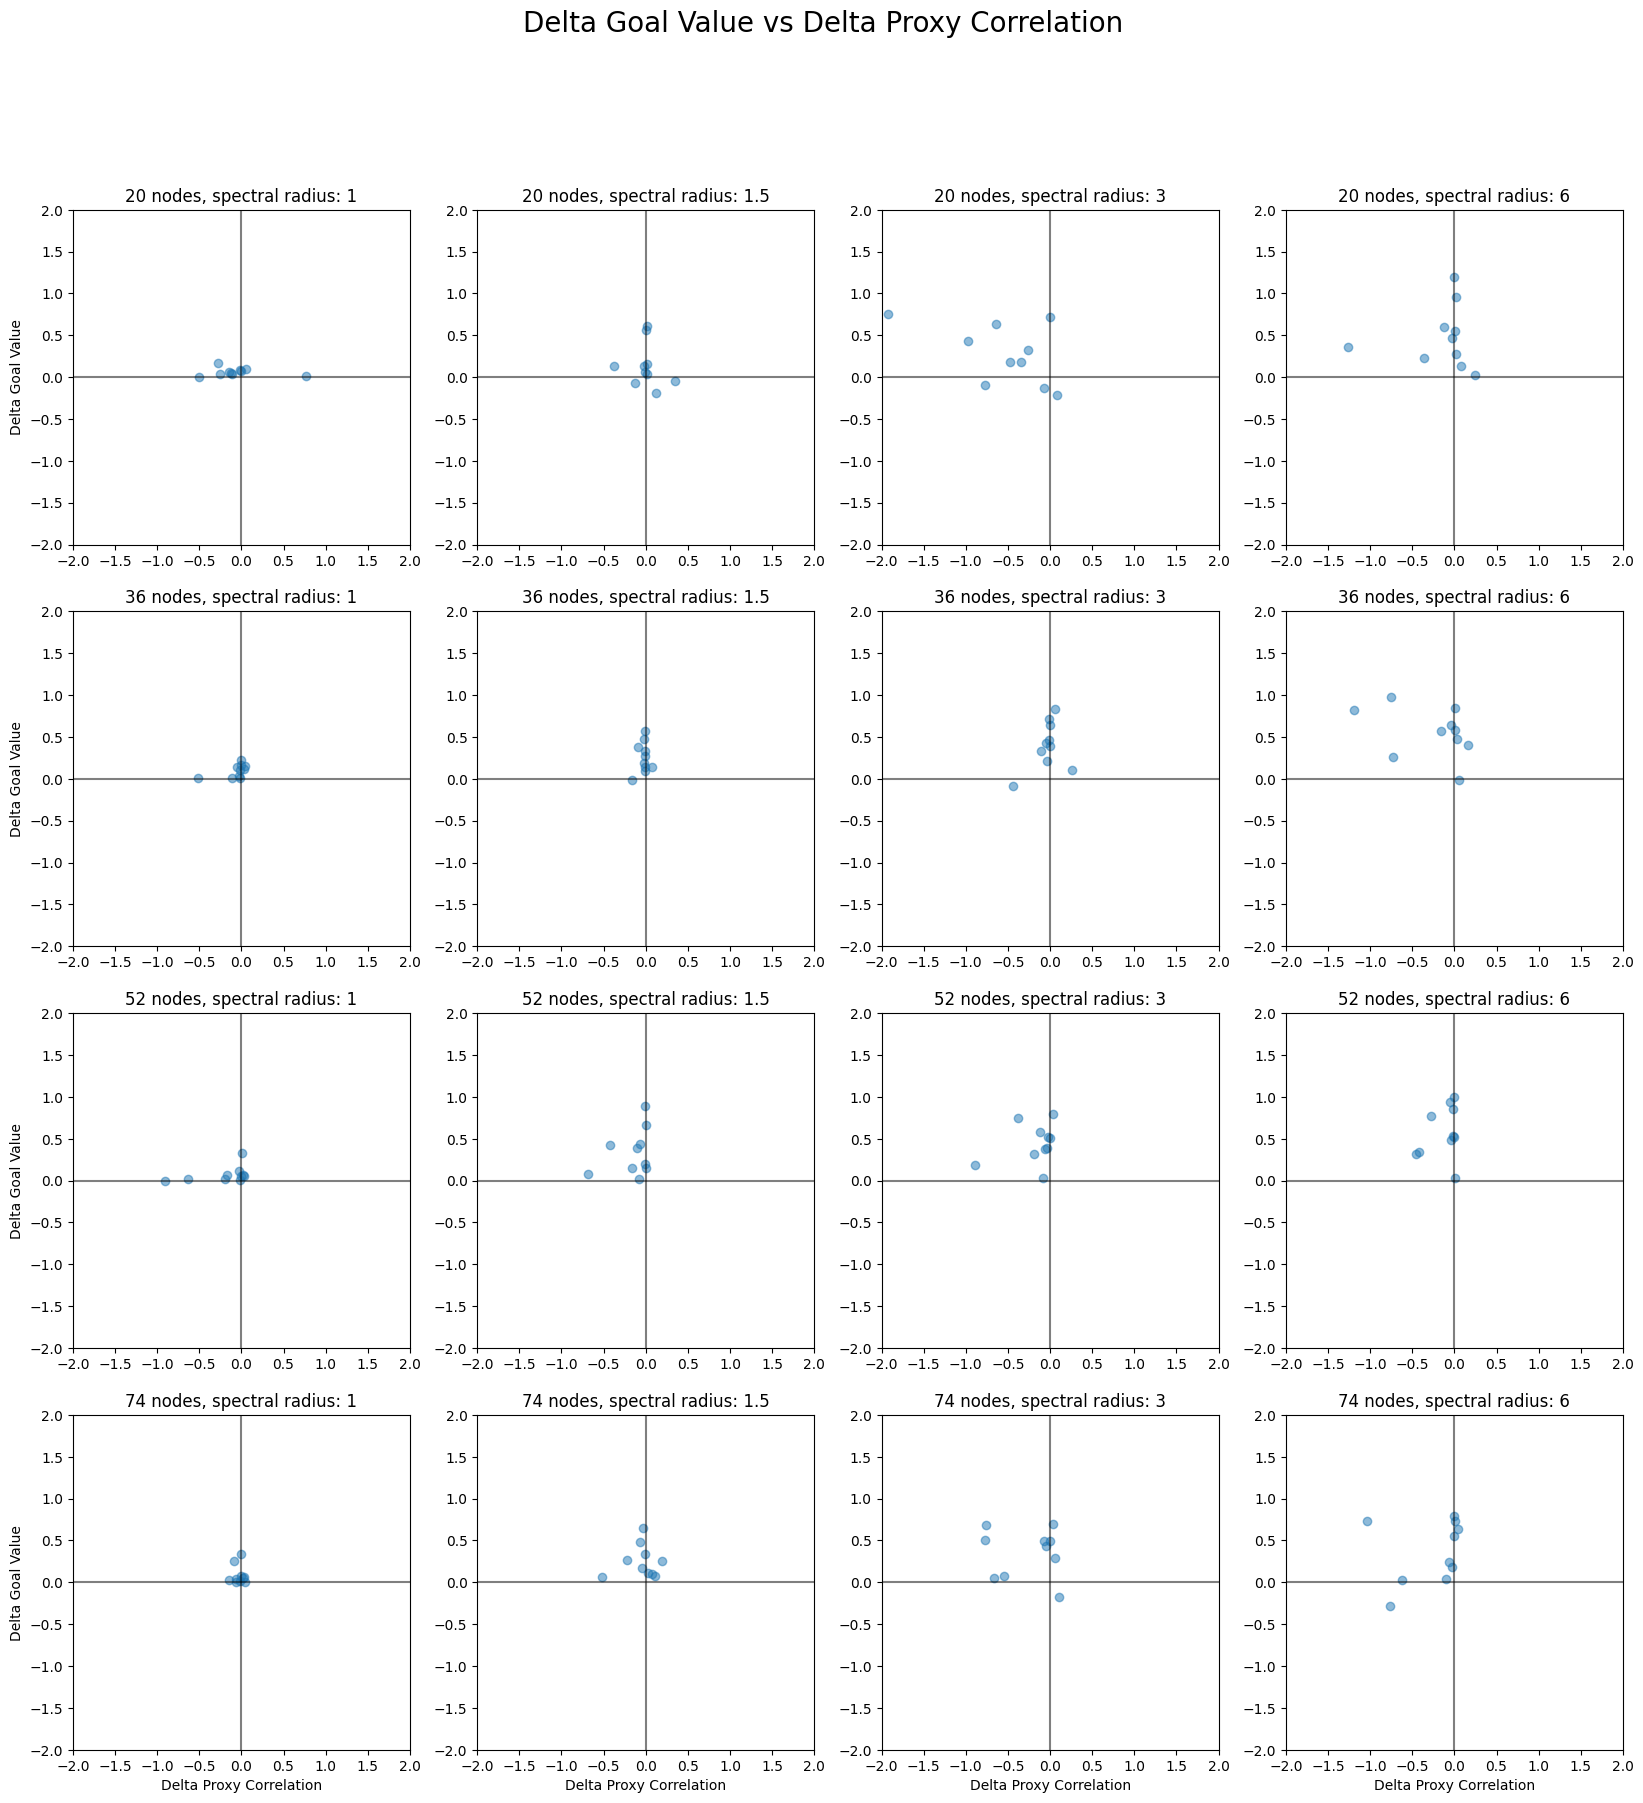

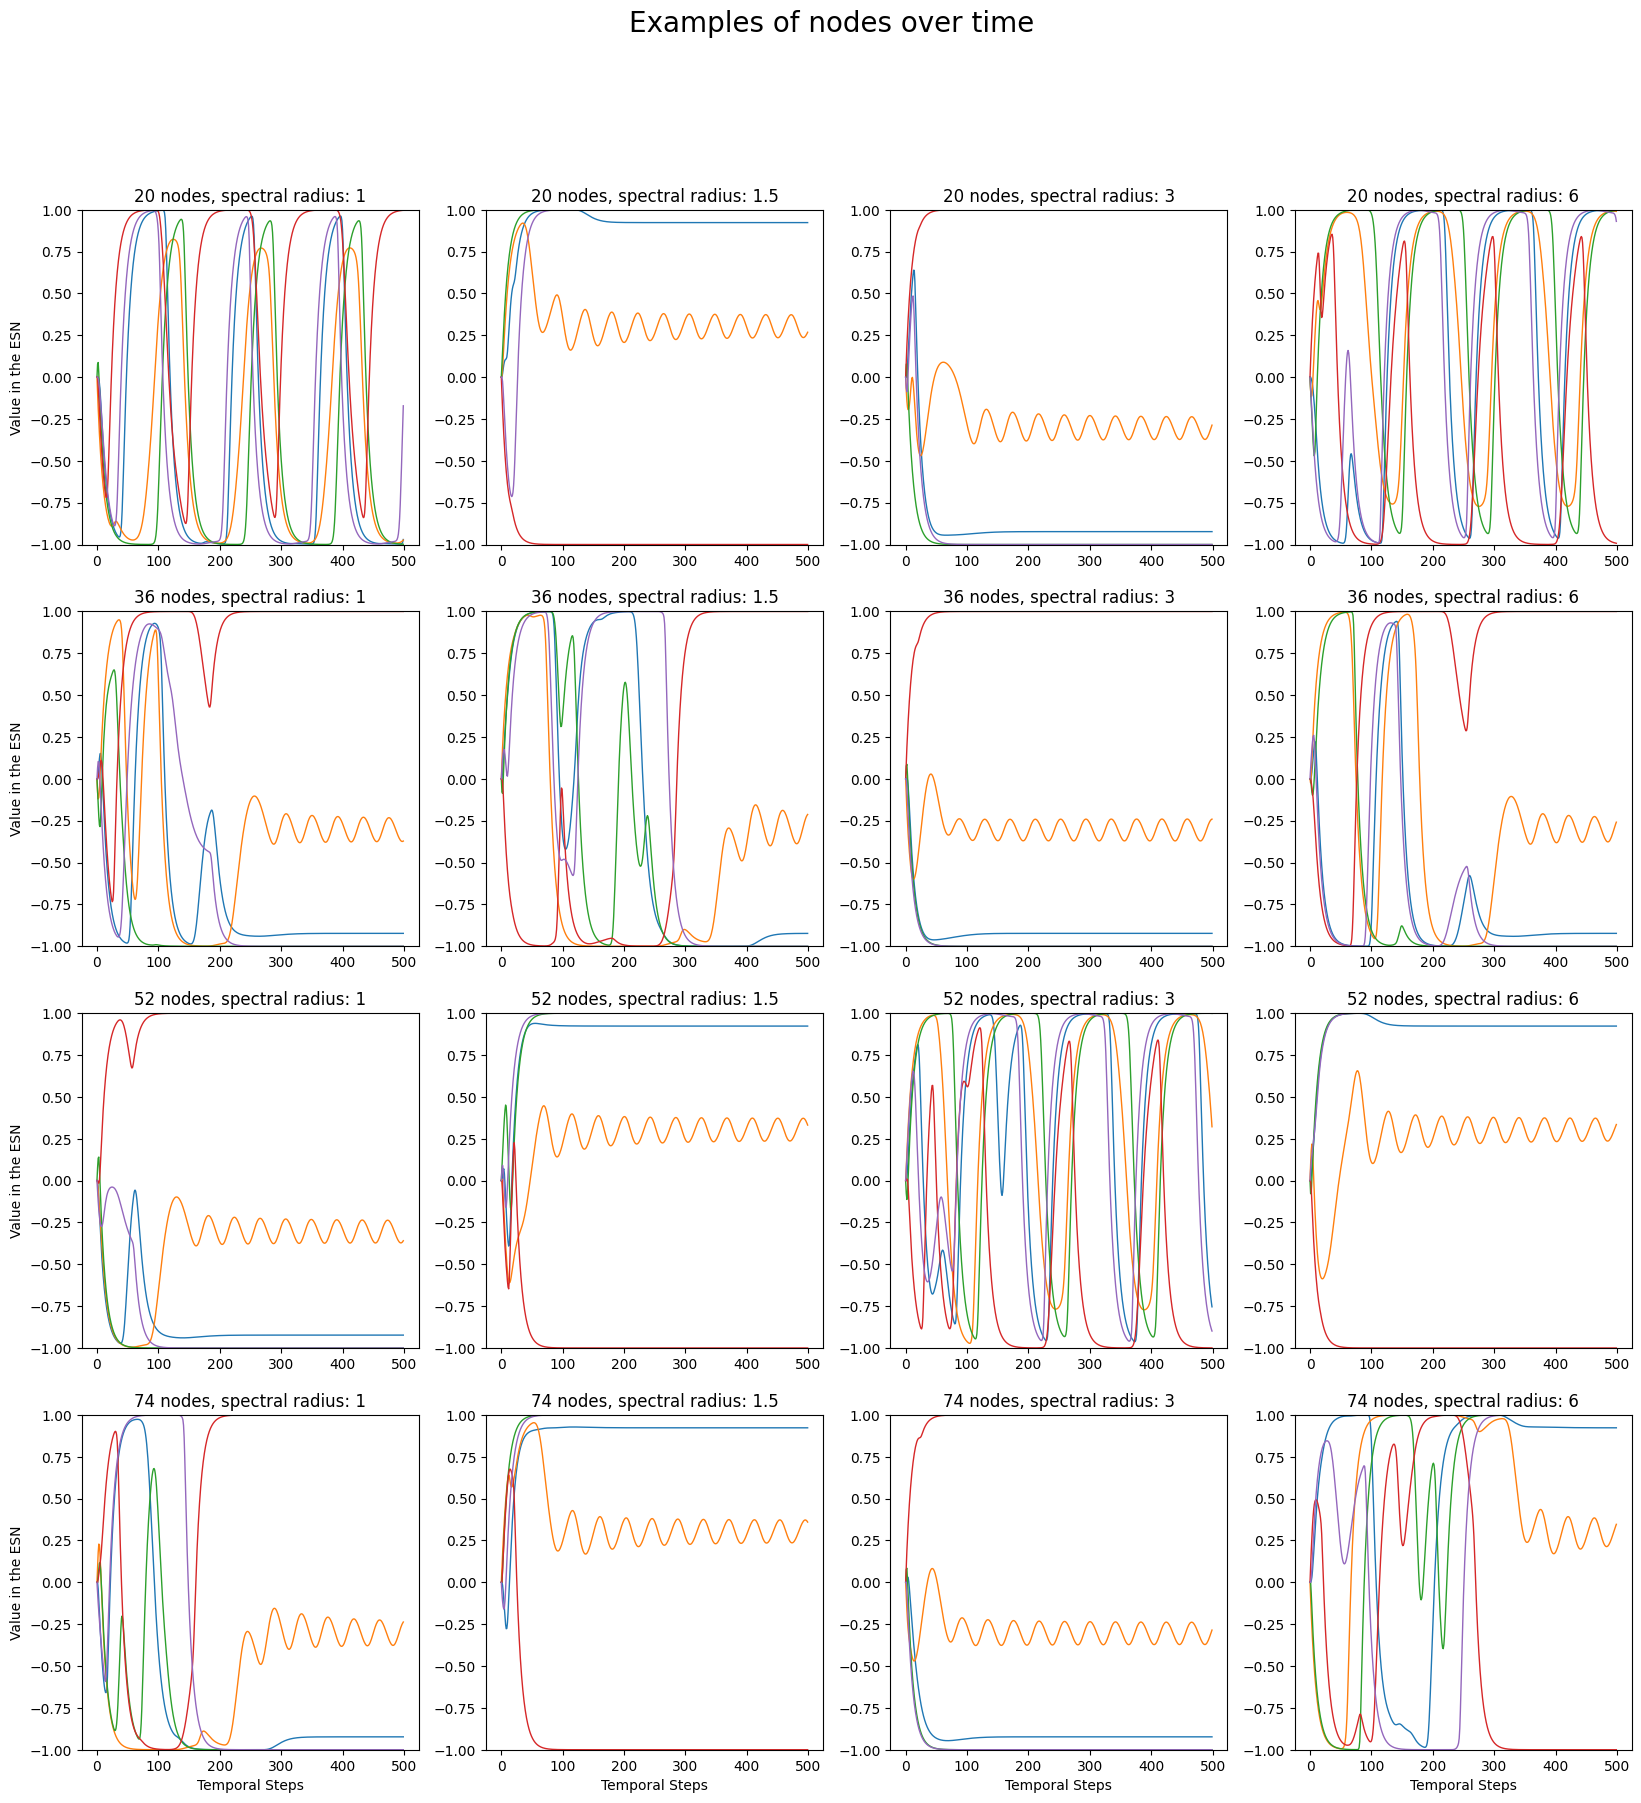

In [ ]:
# create a dictionary with multiple value of a the parameters and try all the combinations  
import json
from joblib import Parallel, delayed
save = True


param_grid = {
    'n':  [20,36, 52,74], #[120,360, 1080,3240], #
    'k': [16],
    'num_proxy_nodes': [1],
    'trials': [10],
    'discard': [ 50], #[ 500],# 
    'add_steps': [50],
    'inverse': [False],
    'plot': [True],
    'spectral_radius': [1,1.5,3,6],
    'alpha': [0.1],
    "avg_number_of_edges": [5]
}

param_exp = {}
number_of_instance =10 #  100 # 

# creates a list of the parameters that will vary
varying_params = [a for a in param_grid.keys() if len(param_grid[a]) > 1]
# Create a list of all combinations of parameters

param_combinations = list(product(*param_grid.values()))
print("param_combinations", len(param_combinations))
# Create a list of parameter names
param_names = list(param_grid.keys())
# Loop through all combinations of parameters

# plot initialization
Figs = [0 for k in range(5)]
Axes = [0 for k in range(5)]
Titles = ['Network correlations', 'Delta Goal Value', 'Delta Proxy Correlation', 'Delta Goal Value vs Delta Proxy Correlation','Examples of nodes over time']
for k in range(5):        
        Figs[k], axes = plt.subplots(4, 4, figsize=(20, 20))
        Figs[k].suptitle(Titles[k], fontsize=20)
        Axes[k] = axes.flatten()


#function to parallelize 

def parallel_compute_proxy_nodes(param_exp,param_ESN):
    esn = module.EchoStateNetwork(param_ESN['n'],  spectral_radius=param_ESN['spectral_radius'], alpha = param_ESN['alpha'], 
                                avg_number_of_edges=param_ESN['avg_number_of_edges'], action_nodes=param_ESN['action_nodes'])
    param_exp['esn'] = esn
    # Compute proxy nodes
    goal_nodes = np.array([param_ESN['n']-1])
    proxy_nodes, goal_base, proxy_base, correlations = compute_proxy_nodes_from_esn(**param_exp)
    correlation_base = np.mean(correlations[proxy_nodes])
    next_dict ={ **{i:param_exp[i] for i in param_exp if i!='num_proxy_nodes'}, 'proxy_nodes':proxy_nodes}
    maxed_goal_value, maxed_proxy_value, correlation_on_max_proxy = run_proxy_optimization_test(**next_dict )
    next_dict ={ **{i:param_exp[i] for i in param_exp if i!='num_proxy_nodes'}, 'proxy_nodes':goal_nodes}
    optimal_goal_value, optimal_proxy_value, correlation_on_optimal_proxy = run_proxy_optimization_test(**next_dict )
    to_return = {
        'correlations': correlations,
        'maxed_goal_value': maxed_goal_value,
        'goal_base': goal_base,
        'maxed_proxy_value': maxed_proxy_value,
        'correlation_on_max_proxy': correlation_on_max_proxy,
        'correlation_base': correlation_base,
        'optimal_goal_value': optimal_goal_value,
        'optimal_proxy_value': optimal_proxy_value,
        'correlation_on_optimal_proxy': correlation_on_optimal_proxy
    } 
    return to_return


for k in range(len(param_combinations)):
    params = param_combinations[k]
    # Create a dictionary of parameters
    param_ESN = dict(zip(param_names, params))
    name = 'ESN_'+ "".join([a +'_'+ str(b) for (a,b) in list(zip(param_names, params)) if a in varying_params])
    print("instance", k+1, "out of ", len(param_combinations), "name", figure_name)

    #param_dict["figname"] = figure_name
    param_ESN['action_nodes'] = np.array([j for j in range(param_ESN['k'])])
    param_exp["action_nodes"] = param_ESN['action_nodes']
    param_exp["steps"] = param_ESN['add_steps'] + param_ESN['discard']
    param_exp['trials'] = param_ESN['trials']
    param_exp["num_proxy_nodes"] = param_ESN['num_proxy_nodes']
    param_exp['discard'] = param_ESN['discard']
    param_exp['inverse'] = param_ESN['inverse']
    esnList = []
    correlations_list = []
    delta_goal_values = []
    delta_optimal_goal = []
    delta_proxy_correlations = []
    List_output = []
    # run the parallel computation of proxy nodes
    List_output = Parallel(n_jobs=-1, return_as='list')(
        [delayed(parallel_compute_proxy_nodes)(param_exp,param_ESN) for _ in range(number_of_instance)]
    )

    for temp_dict in List_output:
        correlations_list += list(temp_dict['correlations'])
        delta_goal_values.append(temp_dict['maxed_goal_value'] - temp_dict['goal_base'])
        delta_proxy_correlations.append(temp_dict['correlation_on_max_proxy'] - temp_dict['correlation_base'])
        delta_optimal_goal.append(temp_dict['optimal_goal_value'] - temp_dict['goal_base'])
        if save:
            to_save = { **dict(zip(param_names, params)), **temp_dict}
            append_to_json(to_save,'parameter_exploration/example_memory.json')

    
    # fill the subfigures with the results
    Axes[0][k].hist(correlations_list, bins=20, alpha=0.5, range=[-1, 1], label='Correlations', color='blue')
    y, x, _= Axes[1][k].hist(delta_goal_values, bins=20, alpha=0.5, range=[-2, 2], label='Delta Goal Values', color='blue') 
    y2, x, _= Axes[1][k].hist(delta_optimal_goal, bins=20, alpha=0.5, range=[-2, 2], label='Optimal Delta Values', color='green') 
    
    goal_text_y = 0.9*max(y, y2)
    y, x, _ =Axes[2][k].hist(delta_proxy_correlations, bins=20, alpha=0.5, range=[-2, 2], label='Delta Proxy Correlations', color='red')
    prox_text_y = 0.9*max(y)
    Axes[3][k].axhline(y=0, color='k', alpha=0.5)
    Axes[3][k].axvline(x=0, color='k',alpha=0.5)
    Axes[3][k].scatter(delta_proxy_correlations,delta_goal_values,  alpha=0.5)

    Axes[3][k].set_xlim(-2, 2)
    Axes[3][k].set_ylim(-2, 2)

    plot_example_esn(Axes[4][k], esn, steps=500, discard=0, action_nodes=param_exp["action_nodes"])

    for j in range(5):
        Axes[j][k].set_title( str(param_ESN['n']) + ' nodes, spectral radius: ' + str(param_ESN['spectral_radius']))

    # add information on the figure
    prop_delta_goal_below0 = 100*len([k for k in delta_goal_values if k < 0])/ len(delta_goal_values)
    Axes[1][k].text(-1.95, goal_text_y, 'avg Value: {:.2f}'.format(np.mean(delta_goal_values)) + '\n{:.2f}% < 0'.format(prop_delta_goal_below0), fontsize=12, ha='left')
    Axes[2][k].text(-1.95, prox_text_y, 'avg Value: {:.2f}'.format(np.mean(delta_proxy_correlations)), fontsize=12, ha='left')

    # add label to the y-axis only on the first column
    if k % 4 == 0:
        Axes[0][k].set_ylabel('Frequency')
        Axes[1][k].set_ylabel('Frequency')
        Axes[2][k].set_ylabel('Frequency')
        Axes[3][k].set_ylabel('Delta Goal Value')
        Axes[4][k].set_ylabel('Value in the ESN')

    # add label to the x axis only on the last row
    if k >= 12:
        Axes[0][k].set_xlabel('Correlation with Goal Nodes')
        Axes[1][k].set_xlabel('Delta Goal Value')
        Axes[2][k].set_xlabel('Delta Proxy Correlation')
        Axes[3][k].set_xlabel('Delta Proxy Correlation')
        Axes[4][k].set_xlabel('Temporal Steps')



handles, labels = Axes[1][0].get_legend_handles_labels()
Figs[1].legend(handles, labels, loc='upper center')
if save:
    # save the figure
    Figs[0].savefig('parameter_exploration/ESN_correlations.png')
    Figs[1].savefig('parameter_exploration/ESN_delta_goal_values.png')
    Figs[2].savefig('parameter_exploration/ESN_delta_proxy_correlations.png')
    Figs[3].savefig('parameter_exploration/ESN_delta_goal_vs_proxy_correlations.png')
    Figs[4].savefig('parameter_exploration/ESN_examples.png')



    


# test 

In [ ]:
# make a 2 dimensional of size n with random values between -1 and 1
YAa= np.random.uniform(-1, 1, (10000, 10000 ))

YAa[proxy_nodes, goal_nodes]



array([-0.68626747])

In [8]:
16*60/5


192.0